In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm as cm_mlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy
%matplotlib inline
plt.viridis()
from matplotlib import animation, rc, colors
from IPython.display import HTML
from brian2.units import *
import matplotlib as mlib
from scipy import stats
from pprint import pprint as pp
from mpl_toolkits.axes_grid1 import make_axes_locatable
from simulation_statistics.analysis_functions_definitions import *

In [2]:
mlib.rcParams.update({'font.size': 24})
mlib.rcParams.update({'errorbar.capsize': 5})
mlib.rcParams.update({'figure.autolayout': True})

In [213]:

def distance(x0, x1, grid=np.asarray([16, 16]), type='euclidian'):
    x0 = np.asarray(x0)
    x1 = np.asarray(x1)
    delta = np.abs(x0 - x1)
#     delta = x0 - x1
    if delta[0] > grid[0] * .5 and grid[0] > 0:
        delta[0] -= grid[0]

    if delta[1] > grid[1] * .5 and grid[1] > 0:
        delta[1] -= grid[1]

    if type == 'manhattan':
        return np.abs(delta).sum(axis=-1)
    elif type == 'equidistant':
        p=4
        exponents = np.power(delta, [p]*delta.size)
        return np.floor(np.power(exponents.sum(axis=-1), [1./p]))
#         return np.power(exponents.sum(axis=-1), [1./p])
#         return np.floor(np.abs(delta).sum(axis=-1))
#         return np.floor(np.sqrt(((delta) ** 2).sum(axis=-1)))
    return np.sqrt((delta ** 2).sum(axis=-1))

def generate_rates(s, grid=np.asarray([16, 16]), f_base=5., f_peak=152.8, sigma_stim=2., type='euclidian'):
    ''' 
    Function that generates an array the same shape as the input layer so that
    each cell has a value corresponding to the firing rate for the neuron
    at that position.
    '''
    _rates = np.empty(grid)
    for x in range(grid[0]):
        for y in range(grid[1]):
            _d = distance(s, (x, y), grid, type=type)
            _rates[x, y] = f_base + (f_peak * (np.exp(
                -(_d / (2 *sigma_stim ** 2)))))
    return _rates

def generate_gaussian_rates(s, grid=np.asarray([16, 16]), f_base=5., f_peak=152.8, sigma_stim=2., type='euclidian'):
    ''' 
    Function that generates an array the same shape as the input layer so that
    each cell has a value corresponding to the firing rate for the neuron
    at that position.
    '''
    _rates = np.empty(grid)
    for x in range(grid[0]):
        for y in range(grid[1]):
            _d = distance(s, (x, y), grid, type=type)
            _rates[x, y] = f_peak * (np.exp(
                (-_d**2 ) / (sigma_stim ** 2* 2)))
    
    means_ratio = float(f_mean - f_base) / np.mean(_rates)       
    _rates = _rates * means_ratio + f_base
    
    assert np.isclose(np.mean(_rates), f_mean, 0.01, 0.01), "{} vs. {}".format(np.mean(_rates), f_mean)
    
    return _rates

def generate_multimodal_gaussian_rates(s, grid, f_base=5, f_peak=152.8, sigma_stim=2):
    '''
    Function that generates an array the same shape as the input layer so that
    each cell has a value corresponding to the firing rate for the neuron
    at that position.
    '''
    _rates = np.zeros(grid)
    for pos in s:
        for x in range(grid[0]):
            for y in range(grid[1]):
                _d = distance(pos, (x, y), grid)
                _rates[x, y] += (f_peak * (np.exp(
                    (-_d ** 2) / (sigma_stim ** 2 * 2))))

    for x in range(grid[0]):
        for y in range(grid[1]):
            _rates[x, y] += f_base
    return _rates

In [214]:
f_mean = 20
f_peak = 152.8
f_base = 5
sigma_stim = 2
location = [32//2, 32//2]
rates = generate_gaussian_rates(location, 
                            grid=[32,32],
                           f_base=f_base,
                           f_peak=f_peak,
                           sigma_stim=5)
equ_rates = generate_gaussian_rates(location, 
                            grid=[32,32],
                           f_base=f_base,
                           f_peak=f_peak,
                           sigma_stim=5,
                           type='equidistant')
print np.max(rates)
print np.std(rates)
print np.mean(rates)

print np.max(equ_rates)
print np.std(equ_rates)
print np.mean(equ_rates)

103.064059225
22.640025704
20.0
84.0068613798
19.4515098955
20.0


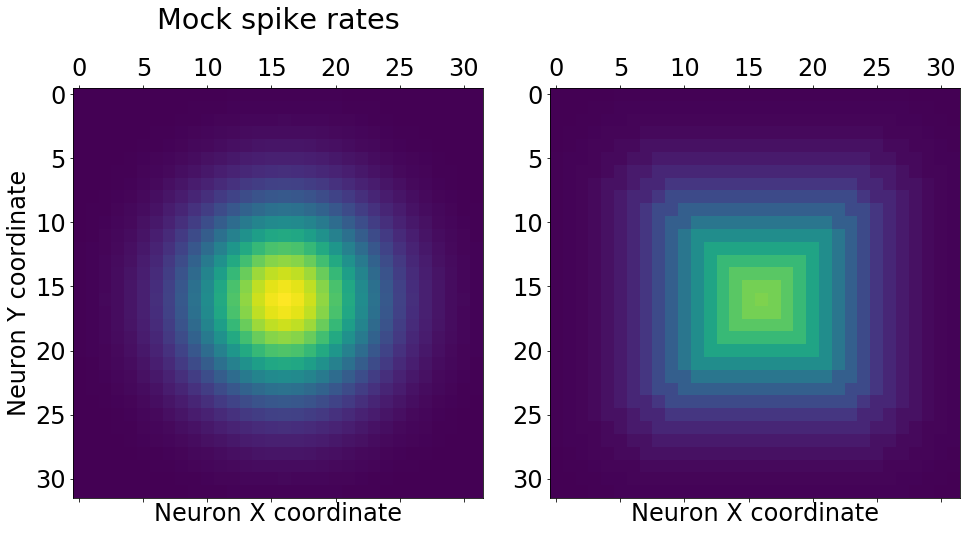

In [246]:
f, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(14,8))
maximus = np.max((rates, equ_rates))
i = ax1.matshow(rates, vmax=maximus)
cax = divider.append_axes("right", "5%", pad="3%")
cbar = plt.colorbar(i, cax=cax)
cbar.set_label("Spike rate (Hz)")
i2 = ax2.matshow(equ_rates, vmax=maximus)
cax = divider.append_axes("right", "5%", pad="3%")
cbar = plt.colorbar(i2, cax=cax)
cbar.set_label("Spike rate (Hz)")
ax1.grid(visible=False)
ax1.set_title("Mock spike rates\n")
ax1.set_xlabel("Neuron X coordinate")
ax2.set_xlabel("Neuron X coordinate")
ax1.set_ylabel("Neuron Y coordinate")
divider = make_axes_locatable(plt.gca())

plt.tight_layout(.3)

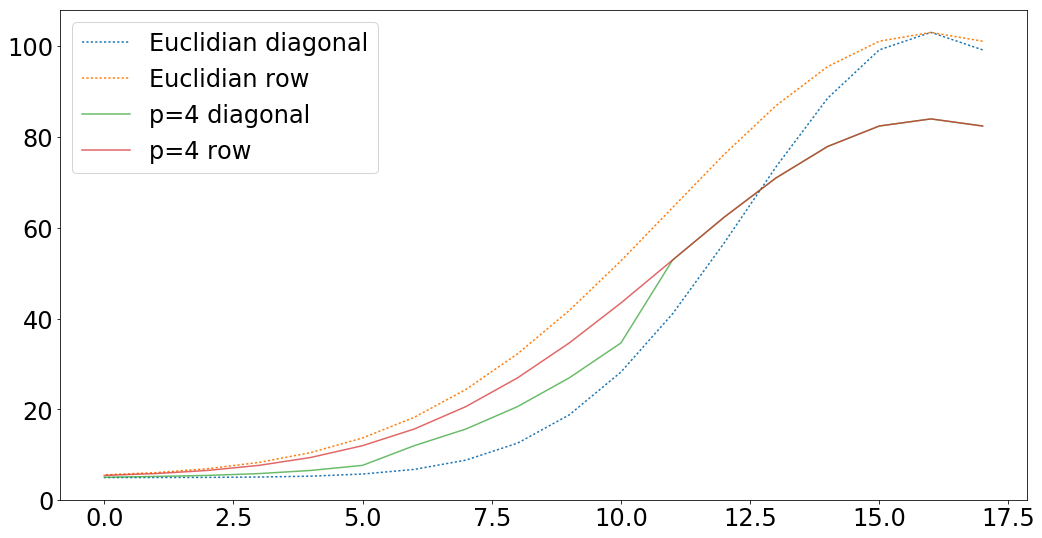

In [236]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(15,8))
ax1.plot(range(location[0]+1, -1, -1), [rates[i,i] for i in range(location[0]+1, -1, -1)], label="Euclidian diagonal", alpha=1, ls=':')
ax1.plot(range(location[0]+1, -1, -1), [rates[location[0],i] for i in range(location[0]+1, -1, -1)], label="Euclidian row", alpha=1, ls=':')
ax1.plot(range(location[0]+1, -1, -1), [equ_rates[i,i] for i in range(location[0]+1, -1, -1)], label="p=4 diagonal", alpha=0.7)
ax1.plot(range(location[0]+1, -1, -1), [equ_rates[location[0],i] for i in range(location[0]+1, -1, -1)], label="p=4 row", alpha=0.7)
plt.legend(loc="best")

In [237]:
r1 = np.asarray([rates[location[0],i] for i in range(-location[0], location[0], 1)])
e1 = np.asarray([equ_rates[location[0],i] for i in range(-location[0], location[0], 1)])

r2 = np.asarray([rates[i,i] for i in range(-location[0], location[0], 1)])
e2 = np.asarray([equ_rates[i,i] for i in range(-location[0], location[0], 1)])

In [238]:
r1 / e1

array([ 1.22685287,  1.22658044,  1.22573387,  1.22422093,  1.22187266,
        1.21841943,  1.2134566 ,  1.20640501,  1.19648609,  1.18276374,
        1.164354  ,  1.14091792,  1.11338291,  1.08437588,  1.05757304,
        1.03601865,  1.02081199,  1.03601865,  1.05757304,  1.08437588,
        1.11338291,  1.14091792,  1.164354  ,  1.18276374,  1.19648609,
        1.20640501,  1.2134566 ,  1.21841943,  1.22187266,  1.22422093,
        1.22573387,  1.22658044])

In [239]:
r2 / e2

array([ 1.22685287,  1.20349344,  1.13642768,  1.03415726,  0.90921513,
        0.77618455,  0.81478627,  0.69763971,  0.60967289,  0.5633658 ,
        0.56514509,  0.75102873,  0.80836605,  0.87001549,  0.92077295,
        0.95577301,  0.98926113,  0.95577301,  0.92077295,  0.87001549,
        0.80836605,  0.75102873,  0.56514509,  0.5633658 ,  0.60967289,
        0.69763971,  0.81478627,  0.77618455,  0.90921513,  1.03415726,
        1.13642768,  1.20349344])

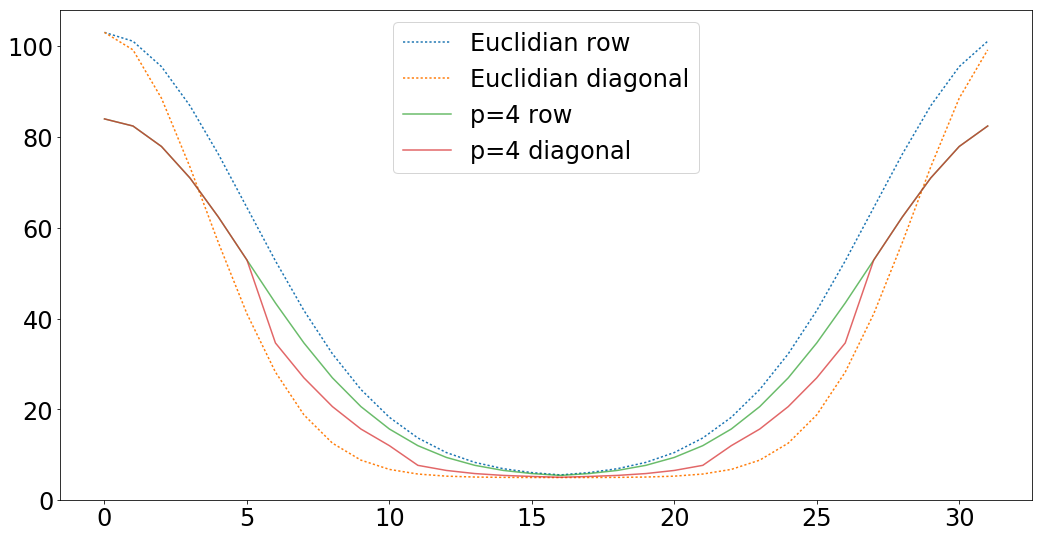

In [242]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(15,8))
ax1.plot(r1, label="Euclidian row", alpha=1, ls=':')
ax1.plot(r2, label="Euclidian diagonal", alpha=1, ls=':')
ax1.plot(e1, label="p=4 row", alpha=0.7)
ax1.plot(e2, label="p=4 diagonal", alpha=0.7)
plt.legend(loc="best")

In [243]:
np.sum(rates)

20480.0

In [244]:
np.sum(equ_rates)

20480.0